Fitted 'a' coefficient: 2.6487
Fitted 'b' coefficient: 1.2850
Covariance matrix diagomal values: [0.01388024 0.00014682]


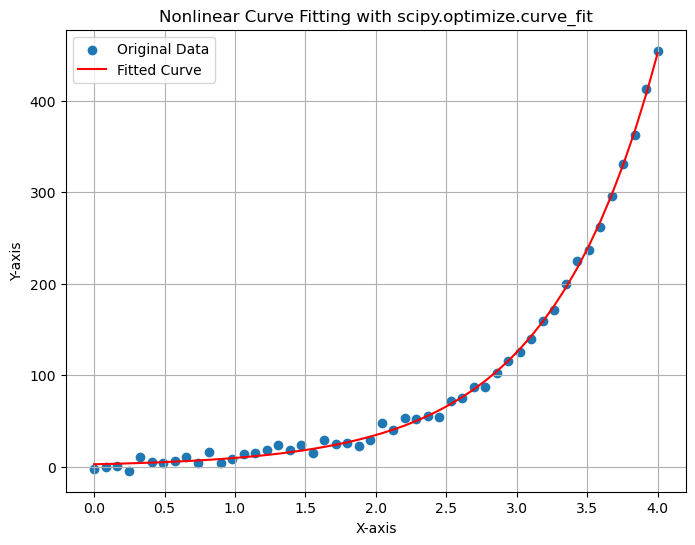

In [1]:
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

# 1. Generate some sample data (for demonstration purposes)
# In a real scenario, you'd load your actual independent and dependent data
x_data = np.linspace(0, 4, 50)
true_a = 2.5
true_b = 1.3
y_data = true_a * np.exp(true_b * x_data) + 10*np.random.normal(0, 0.5, x_data.size) # Added some noise

# 2. Define your nonlinear function
def exponential_function(x, a, b):
    return a * np.exp(b * x)

# 3. Use curve_fit to find the coefficients
# p0 is an optional initial guess for the parameters [a, b]
initial_guess = [1.0, 1.0]
popt, pcov = curve_fit(exponential_function, x_data, y_data, p0=initial_guess)

# Extract the optimized coefficients
a_fit, b_fit = popt

print(f"Fitted 'a' coefficient: {a_fit:.4f}")
print(f"Fitted 'b' coefficient: {b_fit:.4f}")
print(f"Covariance matrix diagomal values: {np.diag(pcov)}")

# 4. Plot the original data and the fitted curve
plt.figure(figsize=(8, 6))
plt.scatter(x_data, y_data, label='Original Data')
plt.plot(x_data, exponential_function(x_data, a_fit, b_fit), color='red', label='Fitted Curve')
plt.title('Nonlinear Curve Fitting with scipy.optimize.curve_fit')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.legend()
plt.grid(True)
plt.show()

In [2]:
import numpy as np
from scipy.optimize import minimize

# --- Problem Parameters (Constants) ---
# Material properties (assuming steel)
YOUNG_MODULUS = 200 * (10**9)  # Young's Modulus (E) in Pa (N/m^2) - 200 GPa
DENSITY = 7850               # Density (rho) in kg/m^3
ALLOWABLE_STRESS = 250 * (10**6) # Allowable stress (sigma_allow) in Pa - 250 MPa

# Bridge geometry and loading
SPAN_LENGTH = 10             # Length of the beam (L) in meters
POINT_LOAD = 100 * (10**3)   # A concentrated point load (P) in Newtons - 100 kN

# Constraints for deflection (delta_allow)
# A typical deflection limit might be Span/360 or Span/500
ALLOWABLE_DEFLECTION = SPAN_LENGTH / 500 # Max allowed deflection in meters

# --- Design Variables (what we want to optimize) ---
# For simplicity, we're optimizing the cross-sectional area (A) of a single beam.
# In a real bridge, this would be an array of many dimensions.
# Let's assume a rectangular cross-section for simplicity where
# Area = width * height.
# For a rectangular section, Moment of Inertia (I) = (width * height^3) / 12
# We'll assume a fixed width and optimize for height,
# or directly optimize for Area and calculate I based on Area and assumed shape.
# Let's directly optimize for Area for now, and relate I to A for a common shape
# e.g., if we assume a square beam, then width = height = sqrt(A)
# I = (sqrt(A) * (sqrt(A))^3) / 12 = A^2 / 12
# This is a simplification. For more complex shapes, A and I are independently optimized or related differently.

# Let's use a more realistic simplification:
# Assume a circular cross-section or an I-beam where I is proportional to A^2
# For a solid circular section, A = pi*r^2, I = pi*r^4 / 4 = A^2 / (4*pi)
# For this example, let's just make I directly proportional to A (simplified)
# I = k * A, where k is some constant related to shape efficiency.
# A better approach is to define actual dimensions (e.g., width, height) as variables.

# Let's define dimensions: width (b) and height (h) as optimization variables
# For a rectangular cross-section:
# Area (A) = b * h
# Moment of Inertia (I) = (b * h^3) / 12

# Initial guess for the design variables: [width, height] in meters
# Let's start with a beam that's 0.2m wide and 0.5m high
initial_guess_dims = [0.2, 0.5]

# Bounds for the design variables: [ (min_width, max_width), (min_height, max_height) ]
bounds_dims = [(0.1, 1.0), (0.1, 2.0)] # Width from 10cm to 1m, Height from 10cm to 2m

# --- Objective Function (Minimize Weight) ---
def objective(dims):
    """
    Calculates the total weight of the beam.
    dims = [width, height]
    """
    width, height = dims
    area = width * height
    volume = area * SPAN_LENGTH
    weight = DENSITY * volume
    return weight

# --- Constraint Functions ---
# Constraints must be defined such that they are >= 0 for feasible solutions.

def stress_constraint(dims):
    """
    Calculates the stress in the beam and returns (ALLOWABLE_STRESS - max_stress).
    max_stress <= ALLOWABLE_STRESS  =>  ALLOWABLE_STRESS - max_stress >= 0
    For a simply supported beam with a central point load:
    Max Bending Moment (M_max) = P * L / 4
    Stress (sigma) = M_max * y / I, where y is distance from neutral axis (h/2 for rectangle)
    """
    width, height = dims
    area = width * height
    moment_of_inertia = (width * height**3) / 12

    if moment_of_inertia <= 0: # Avoid division by zero or negative I
        return -np.inf # Makes this constraint heavily violated

    max_bending_moment = (POINT_LOAD * SPAN_LENGTH) / 4
    y_max = height / 2 # Distance from neutral axis to extreme fiber
    max_stress = (max_bending_moment * y_max) / moment_of_inertia

    return ALLOWABLE_STRESS - max_stress

def deflection_constraint(dims):
    """
    Calculates the maximum deflection and returns (ALLOWABLE_DEFLECTION - max_deflection).
    max_deflection <= ALLOWABLE_DEFLECTION => ALLOWABLE_DEFLECTION - max_deflection >= 0
    For a simply supported beam with a central point load:
    Max Deflection (delta_max) = (P * L^3) / (48 * E * I)
    """
    width, height = dims
    area = width * height
    moment_of_inertia = (width * height**3) / 12

    if moment_of_inertia <= 0: # Avoid division by zero or negative I
        return -np.inf # Makes this constraint heavily violated

    max_deflection = (POINT_LOAD * SPAN_LENGTH**3) / (48 * YOUNG_MODULUS * moment_of_inertia)

    return ALLOWABLE_DEFLECTION - max_deflection

# --- Setup Constraints for SciPy ---
constraints = [
    {'type': 'ineq', 'fun': stress_constraint},
    {'type': 'ineq', 'fun': deflection_constraint}
]

# --- Run the Optimization ---
result = minimize(objective, initial_guess_dims,
                  method='SLSQP',
                  bounds=bounds_dims,
                  constraints=constraints,
                  options={'disp': True, 'ftol': 1e-6}) # ftol is function tolerance for convergence

# --- Display Results ---
if result.success:
    optimized_width, optimized_height = result.x
    optimized_area = optimized_width * optimized_height
    optimized_weight = result.fun

    print("\n--- Optimization Results ---")
    print(f"Optimization successful: {result.message}")
    print(f"Optimized Width: {optimized_width:.4f} meters")
    print(f"Optimized Height: {optimized_height:.4f} meters")
    print(f"Optimized Cross-sectional Area: {optimized_area:.4f} m^2")
    print(f"Minimum Weight: {optimized_weight:.2f} kg")

    # Verify constraints (re-calculate with optimized values)
    final_stress_margin = stress_constraint(result.x)
    final_deflection_margin = deflection_constraint(result.x)

    print(f"\nStress Constraint Margin (>=0 for feasible): {final_stress_margin:.2f} Pa")
    print(f"Deflection Constraint Margin (>=0 for feasible): {final_deflection_margin:.6f} meters")

    # Calculate actual max stress and deflection
    # Re-calculate moment of inertia with optimized dimensions
    optimized_I = (optimized_width * optimized_height**3) / 12
    actual_max_moment = (POINT_LOAD * SPAN_LENGTH) / 4
    actual_max_stress = (actual_max_moment * (optimized_height / 2)) / optimized_I
    actual_max_deflection = (POINT_LOAD * SPAN_LENGTH**3) / (48 * YOUNG_MODULUS * optimized_I)

    print(f"Actual Max Stress: {actual_max_stress / 1e6:.2f} MPa (Allowable: {ALLOWABLE_STRESS / 1e6:.2f} MPa)")
    print(f"Actual Max Deflection: {actual_max_deflection * 1000:.4f} mm (Allowable: {ALLOWABLE_DEFLECTION * 1000:.4f} mm)")

else:
    print(f"\nOptimization failed: {result.message}")


Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: 3114.5952362934713
            Iterations: 16
            Function evaluations: 58
            Gradient evaluations: 12

Optimization failed: Positive directional derivative for linesearch


/usr/lib/python3/dist-packages/scipy/optimize/_optimize.py:404: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
